In [1]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df = df.sample(n=1000)
print(df.shape)
df.head()

(1000, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
4444829,7,5,568,10690,101.86,31522.0,15.0,130.83,2009.04,1102.0,30.0,1023.0,796.0,2010,1
840204,8,135,605,15934,84.36,31000.0,9.0,112.40,1991.11,166.0,58.0,1215.0,912.0,2007,1
4636556,7,82,1925,8917,84.34,23000.0,17.0,114.61,2001.08,1780.0,510.0,902.0,663.0,2015,2
819325,8,124,1091,4696,183.40,24600.0,4.0,222.79,2000.04,19.0,1.0,443.0,365.0,2015,9
5567390,11,128,1216,11338,59.57,21000.0,12.0,79.34,1995.04,2044.0,888.0,1165.0,875.0,2008,1


In [5]:
y = df['price']
del df['price']

In [6]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [7]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [8]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.90994984, 0.87088928, 0.94476083])

In [9]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

5111.902306481264

In [11]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 14700.000, 예상가격: 14929.999
실제가격: 76800.000, 예상가격: 78693.445
실제가격: 33000.000, 예상가격: 43286.631
실제가격: 16250.000, 예상가격: 16082.018
실제가격: 24000.000, 예상가격: 24572.420
실제가격: 6850.000, 예상가격: 5895.629
실제가격: 9450.000, 예상가격: 8789.497
실제가격: 24900.000, 예상가격: 24486.897
실제가격: 5750.000, 예상가격: 5453.581
실제가격: 18100.000, 예상가격: 18945.282


In [12]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [14]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [15]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 420 samples, validate on 280 samples
Epoch 1/100
420/420 [==============================] - 2s 5ms/step - loss: 975014016.0000 - acc: 0.0000e+00 - val_loss: 990967040.0000 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 990967040.00000, saving model to ./model/01-990967040.0000.hdf5
Epoch 2/100
420/420 [==============================] - 0s 24us/step - loss: 967039360.0000 - acc: 0.0000e+00 - val_loss: 984679424.0000 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 990967040.00000 to 984679424.00000, saving model to ./model/02-984679424.0000.hdf5
Epoch 3/100
420/420 [==============================] - 0s 21us/step - loss: 960271616.0000 - acc: 0.0000e+00 - val_loss: 978575872.0000 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 984679424.00000 to 978575872.00000, saving model to ./model/03-978575872.0000.hdf5
Epoch 4/100
420/420 [==============================] - 0s 21us/step - loss: 953627520


Epoch 00029: val_loss improved from 732868096.00000 to 719025600.00000, saving model to ./model/29-719025600.0000.hdf5
Epoch 30/100
420/420 [==============================] - 0s 17us/step - loss: 675859584.0000 - acc: 0.0000e+00 - val_loss: 705121984.0000 - val_acc: 0.0000e+00

Epoch 00030: val_loss improved from 719025600.00000 to 705121984.00000, saving model to ./model/30-705121984.0000.hdf5
Epoch 31/100
420/420 [==============================] - 0s 12us/step - loss: 661041216.0000 - acc: 0.0000e+00 - val_loss: 691180544.0000 - val_acc: 0.0000e+00

Epoch 00031: val_loss improved from 705121984.00000 to 691180544.00000, saving model to ./model/31-691180544.0000.hdf5
Epoch 32/100
420/420 [==============================] - 0s 14us/step - loss: 646178624.0000 - acc: 0.0000e+00 - val_loss: 677237888.0000 - val_acc: 0.0000e+00

Epoch 00032: val_loss improved from 691180544.00000 to 677237888.00000, saving model to ./model/32-677237888.0000.hdf5
Epoch 33/100
420/420 [=====================

Epoch 59/100
420/420 [==============================] - 0s 24us/step - loss: 374160000.0000 - acc: 0.0000e+00 - val_loss: 434910848.0000 - val_acc: 0.0000e+00

Epoch 00059: val_loss improved from 437509856.00000 to 434910848.00000, saving model to ./model/59-434910848.0000.hdf5
Epoch 60/100
420/420 [==============================] - 0s 21us/step - loss: 371217696.0000 - acc: 0.0000e+00 - val_loss: 432215712.0000 - val_acc: 0.0000e+00

Epoch 00060: val_loss improved from 434910848.00000 to 432215712.00000, saving model to ./model/60-432215712.0000.hdf5
Epoch 61/100
420/420 [==============================] - 0s 17us/step - loss: 368144608.0000 - acc: 0.0024 - val_loss: 429339456.0000 - val_acc: 0.0000e+00

Epoch 00061: val_loss improved from 432215712.00000 to 429339456.00000, saving model to ./model/61-429339456.0000.hdf5
Epoch 62/100
420/420 [==============================] - 0s 19us/step - loss: 364869056.0000 - acc: 0.0000e+00 - val_loss: 426208032.0000 - val_acc: 0.0000e+00

Epoch 0


Epoch 00088: val_loss improved from 325518208.00000 to 322166848.00000, saving model to ./model/88-322166848.0000.hdf5
Epoch 89/100
420/420 [==============================] - 0s 21us/step - loss: 247643376.0000 - acc: 0.0000e+00 - val_loss: 318865376.0000 - val_acc: 0.0000e+00

Epoch 00089: val_loss improved from 322166848.00000 to 318865376.00000, saving model to ./model/89-318865376.0000.hdf5
Epoch 90/100
420/420 [==============================] - 0s 24us/step - loss: 244119040.0000 - acc: 0.0000e+00 - val_loss: 315613952.0000 - val_acc: 0.0000e+00

Epoch 00090: val_loss improved from 318865376.00000 to 315613952.00000, saving model to ./model/90-315613952.0000.hdf5
Epoch 91/100
420/420 [==============================] - 0s 26us/step - loss: 240674624.0000 - acc: 0.0000e+00 - val_loss: 312410016.0000 - val_acc: 0.0000e+00

Epoch 00091: val_loss improved from 315613952.00000 to 312410016.00000, saving model to ./model/91-312410016.0000.hdf5
Epoch 92/100
420/420 [=====================

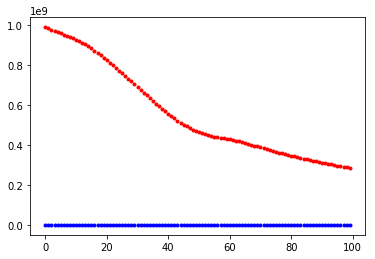

In [16]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [17]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

17102.263476988086

In [18]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 14700.000, 예상가격: 21914.752
실제가격: 76800.000, 예상가격: 51537.148
실제가격: 33000.000, 예상가격: 25678.740
실제가격: 16250.000, 예상가격: 22333.650
실제가격: 24000.000, 예상가격: 24016.127
실제가격: 6850.000, 예상가격: 26264.174
실제가격: 9450.000, 예상가격: 20592.271
실제가격: 24900.000, 예상가격: 25782.516
실제가격: 5750.000, 예상가격: 20722.561
실제가격: 18100.000, 예상가격: 22088.441
